In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Starita_BRCA1_HDR"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [4]:
scoreset

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,brca1_sort1_score,brca1_sort2_score,brca1_sort3_score,brca1_sort4_score,synonymous,nonsense
0,urn:mavedb:00000081-a-2#1,NaN,NaN,p.Val8Trp,0.109929,0.068393,0.154208,0.160836,0.056280,False,False
1,urn:mavedb:00000081-a-2#2,NaN,NaN,p.Val8Ser,0.314116,0.649407,0.007217,0.310740,0.289100,False,False
2,urn:mavedb:00000081-a-2#3,NaN,NaN,p.Val8Pro,-0.288265,-0.425717,0.588212,-1.004666,-0.310891,False,False
3,urn:mavedb:00000081-a-2#4,NaN,NaN,p.Val8Met,0.214284,-0.315936,-0.115324,0.398803,0.889591,False,False
4,urn:mavedb:00000081-a-2#5,NaN,NaN,p.Val8Leu,0.442821,1.745340,NaN,0.000957,-0.417833,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2815,urn:mavedb:00000081-a-2#2816,NaN,NaN,p.Ala102Gln,-0.019377,0.113339,-0.199678,0.108144,-0.099313,False,False
2816,urn:mavedb:00000081-a-2#2817,NaN,NaN,p.Ala102Cys,0.076675,0.317509,-0.884260,0.734668,0.138781,False,False
2817,urn:mavedb:00000081-a-2#2818,NaN,NaN,p.Ala102Asp,-0.086023,0.163494,-0.182905,-0.294175,-0.030509,False,False
2818,urn:mavedb:00000081-a-2#2819,NaN,NaN,p.Ala102Asn,0.206666,0.461364,-0.171476,0.545445,-0.008671,False,False


In [5]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [6]:
AUTHOR_TRANSCRIPT

'NM_007294'

# Add ClinVar annotations

In [7]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

  0%|          | 0/7254 [00:00<?, ?it/s]

100%|██████████| 7254/7254 [00:03<00:00, 1957.74it/s]


In [8]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [9]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [10]:
Ensembl_transcript_stable_ids

array(['ENST00000357654'], dtype=object)

In [11]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [12]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [13]:
scoreset_processed

,hgvs_pro,accession,hgvs_nt,hgvs_splice,score,brca1_sort1_score,brca1_sort2_score,brca1_sort3_score,brca1_sort4_score,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Val8Trp,urn:mavedb:00000081-a-2#1,NaN,NaN,0.109929,0.068393,0.154208,0.160836,0.056280,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Val8Ser,urn:mavedb:00000081-a-2#2,NaN,NaN,0.314116,0.649407,0.007217,0.310740,0.289100,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p.Val8Pro,urn:mavedb:00000081-a-2#3,NaN,NaN,-0.288265,-0.425717,0.588212,-1.004666,-0.310891,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Val8Met,urn:mavedb:00000081-a-2#4,NaN,NaN,0.214284,-0.315936,-0.115324,0.398803,0.889591,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Val8Leu,urn:mavedb:00000081-a-2#5,NaN,NaN,0.442821,1.745340,NaN,0.000957,-0.417833,False,False,0.0,0.0,0.0,0.0,NM_007294.4(BRCA1):c.22G>C (p.Val8Leu),1.0,0.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,p.Ala102Gln,urn:mavedb:00000081-a-2#2816,NaN,NaN,-0.019377,0.113339,-0.199678,0.108144,-0.099313,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2816,p.Ala102Cys,urn:mavedb:00000081-a-2#2817,NaN,NaN,0.076675,0.317509,-0.884260,0.734668,0.138781,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2817,p.Ala102Asp,urn:mavedb:00000081-a-2#2818,NaN,NaN,-0.086023,0.163494,-0.182905,-0.294175,-0.030509,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2818,p.Ala102Asn,urn:mavedb:00000081-a-2#2819,NaN,NaN,0.206666,0.461364,-0.171476,0.545445,-0.008671,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [8]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [15]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [16]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = False
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [17]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 26
B/LB: 23
gnomAD: 162


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

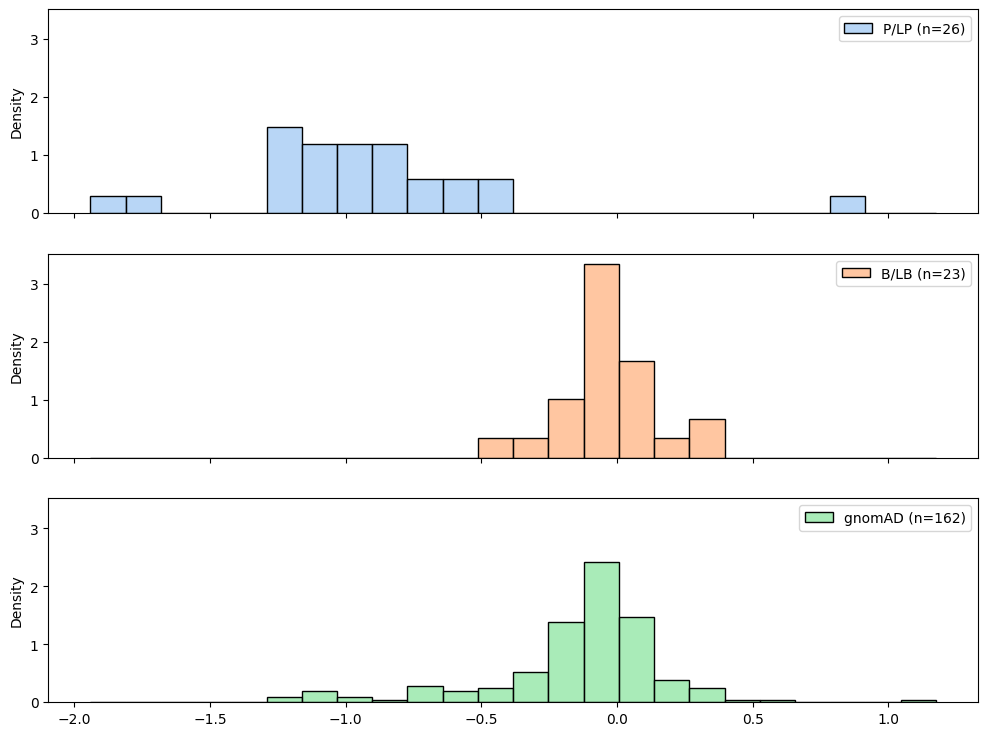

In [18]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [19]:
if 'synonymous' in sample_data:
    pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                                *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                                *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                                *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)
else:
    pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)

In [20]:
old = joblib.load(dataset_path / "hgvs_pro.pkl")

In [21]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['p_lp'].values) - set(sample_data['P/LP'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Arg71Gly,1,0,0,0,NM_007294.4(BRCA1):c.211A>G (p.Arg71Gly),1,0.64
p.Arg71Lys,1,0,0,0,NM_007294.4(BRCA1):c.212G>A (p.Arg71Lys),1,0.65
p.Arg71Met,1,0,0,0,NM_007294.4(BRCA1):c.212G>T (p.Arg71Met),1,0.65
p.Arg71Trp,1,0,0,0,NM_007294.4(BRCA1):c.211A>T (p.Arg71Trp),1,0.63
p.Cys64Gly,1,0,0,0,NM_007294.4(BRCA1):c.190T>G (p.Cys64Gly),1,0.65


In [22]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['b_lb'].values) - set(sample_data['B/LB'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Leu3Phe,0,1,1,0,NM_007294.4(BRCA1):c.9A>T (p.Leu3Phe)|NM_00729...,2,0.03
p.Met48Ile,0,1,1,0,NM_007294.4(BRCA1):c.144G>A (p.Met48Ile)|NM_00...,3,0.14
